247162


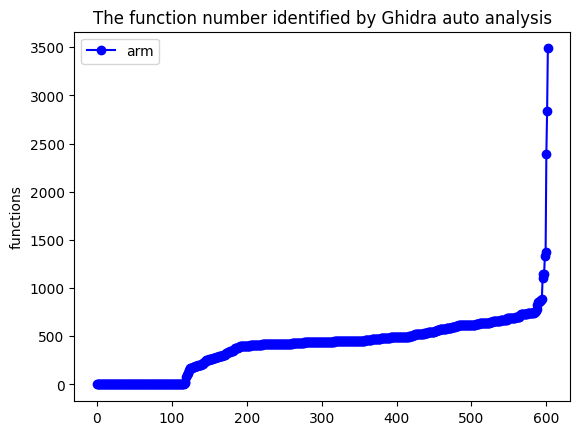

In [52]:
import matplotlib.pyplot as plt

# 你的未排序的数据列表
with open('./bak/func_database.csv') as file:
    funcs_ = file.readlines()

data = []
for line in funcs_:
    data.append(int(line.split(',')[-1][:-1]))    

# 创建 x 轴的索引，可以是数据的索引或者简单的从0开始的数字
x_values = range(len(data))

# 绘制折线图
plt.plot(x_values, sorted(data), marker='o', linestyle='-', color='b', label='arm')

# 添加标题和标签
plt.title('The function number identified by Ghidra auto analysis')
plt.xlabel('')
plt.ylabel('functions')

# 显示图例
plt.legend()

# 显示图形
plt.savefig('./func_analyze.png')

print(sum(data))

In [48]:
from utils.db import *
BIN_DATABASE = './step2_postSig/arm/bin_func.db'
conn = sqlite3.connect(BIN_DATABASE)
cursor = conn.cursor()
cursor.execute('ALTER TABLE func_table RENAME TO old_table;')
conn.commit()
sql_create_table(cursor,FUNC_KEYS,FUNC_TABLE_NAME)
sql_create_index(cursor,FUNC_TABLE_NAME,['hash'],'index_hash')
conn.commit()
conn.close()

CREATE TABLE IF NOT EXISTS func_table (id INTEGER PRIMARY KEY,name TEXT,program TEXT,hash INTEGER,numAddresses INTEGER,mnemonics TEXT,block_num INTEGER,edge_num INTEGER,call_num INTEGER,jump_num INTEGER);
CREATE INDEX IF NOT EXISTS index_hash on func_table(hash);


# Summarize the data 

In [53]:
# The func lists
twr_funcs = set()
twr_num = 0
hal_funcs = set()
hal_num = 0
freertos_funcs = set()
freertos_num = 0
nrf_sdk_programs = set()
nrf_sdk_num = 0 
# The Programs lists 
nrf_mesh_sdk_funcs = set()
mesh_num = 0
arduino_programs = set(['PLC', 'Heat_Press', 'Reflow_Oven', 'Gateway', 'Steering_Control'])
arduino_num = 0

In [54]:
with open('./stm32cubef4-drivers-tags', 'r') as file:
    tags = file.readlines()
for line in tags:
    names = line.split('\t')
    if names[-2] == 'f':
        # the stm hals 
        hal_funcs.add(names[0])

In [55]:
# get the twr-sdk
with open('./twr-tags', 'r') as file:
    tags = file.readlines()
for line in tags:
    names = line.split('\t')
    if names[-2] == 'f':
        # the stm hals 
        if names[1].startswith('stm'):
            hal_funcs.add(names[0])
        else:
            twr_funcs.add(names[0])

In [56]:
# get freertos funcs 
with open('./freertos-tags', 'r') as file:
    tags = file.readlines()
for line in tags:
    names = line.split('\t')
    if names[-2] == 'f':
        freertos_funcs.add(names[0])

In [58]:
# get nrf related funcs
import os 
for root, dirs, files in os.walk('./match_base/nrf-mesh-sdk/'):
    for file in files:
        nrf_mesh_sdk_programs.add(file)

In [75]:
# read match results 
twr_num = 0
hal_num = 0
freertos_num = 0
mesh_num = 0
arduino_num = 0
arduino_results = set()
hal_results = set()
freertos_results = set()
import json
with open('./func_max_match.json') as f:
    data = json.load(f)
for (program, v) in data.items():
    if program in dell:
        print('bypass')
        continue 
    for (func, match) in v.items():
        if match['name'] in twr_funcs:
            twr_num += 1
        if match['name'] in hal_funcs and match['name'] != 'Reset_Handler' and match['name'] != 'main':
            hal_results.add(match['name'])
            hal_num += 1
        if match['name'] in freertos_funcs:
            freertos_results.add(program)
            freertos_num += 1
        # program match 
        if match['program'] in nrf_mesh_sdk_programs:
            mesh_num += 1
        if match['program'] in arduino_programs and match['name'] not in hal_funcs:
            arduino_results.add(match['name'])
            arduino_num += 1

print(f'twr_num = {twr_num},hal_num = {hal_num},freertos_num = {freertos_num},mesh_num = {mesh_num},arduino_num = {arduino_num}')

bypass
twr_num = 16596,hal_num = 6206,freertos_num = 703,mesh_num = 364,arduino_num = 306


In [2]:
import signal

def timeout_handler(signum, frame):
    raise TimeoutError("Timed out!")

def function_with_timeout(seconds):
    signal.signal(signal.SIGALRM, timeout_handler)  # 注册信号处理器
    signal.alarm(seconds)  # 设置闹钟，在指定秒数后发送信号

    try:
        # 这里是你的函数调用
        your_function()
    except TimeoutError:
        print("Function execution timed out!")
    finally:
        signal.alarm(0)  # 清除闹钟设置

# 使用示例：
function_with_timeout(5)

Function execution timed out!


In [1]:
from utils.db import *
#BIN_DATABASE = './step2_postSig/arm/bin_func.db'
DATABASE = './match_base/func.db'
conn = sqlite3.connect(DATABASE)
cursor = conn.cursor()
#cursor.execute('DROP TABLE old_table')
#cursor.execute("SELECT program, COUNT(*) FROM func_table GROUP BY program;")
cursor.execute('SELECT * FROM func_table WHERE program="cf2_nrf.elf"')
results = cursor.fetchall()
conn.commit()
conn.close()

# END

In [ ]:
import os
import subprocess
for root, dirs, files in os.walk('./crypto-cortexm'):
    archives_ = [f[:-2] for f in files if f.endswith('.a')]
    for ar_ in archives_:
        dir_ = root + '/' + ar_
        os.makedirs(dir_)
        subprocess.Popen('ar x ../' + ar_ + '.a', shell=True, cwd=dir_)
    #subprocess.Popen('ls', shell=True, cwd=root)

In [2]:
import sqlite3
BIN_DATABASE = './step2_postSig/arm/bin_func.db'
conn = sqlite3.connect(BIN_DATABASE)
cursor = conn.cursor()
cursor.execute('SELECT DISTINCT program FROM func_table WHERE program NOT LIKE "%noheader"')
result1 = cursor.fetchall()
#results = cursor.fetchall()
conn.close()

dell = []
for i in result1:
    dell.append(i[0] + 'noheader')
import sqlite3

BIN_DATABASE = './step2_postSig/arm/bin_func.db'
conn = sqlite3.connect(BIN_DATABASE)
cursor = conn.cursor()

# 获取原始记录数量
cursor.execute("SELECT COUNT(*) FROM func_table")
initial_count = cursor.fetchone()[0]
print(f'Initial count: {initial_count}')

# 遍历并删除
# 这里假设'dell'变量是一个包含需要删除的program值的列表
for i in dell:
    print(f'Deleting program: {i}')
    cursor.execute(f'DELETE FROM func_table WHERE program = "{i}"')
    
# 提交事务
conn.commit()

# 获取删除后的记录数量
cursor.execute("SELECT COUNT(*) FROM func_table")
final_count = cursor.fetchone()[0]
print(f'Final count: {final_count}')

# 关闭游标和连接
cursor.close()
conn.close()from utils.db import test_import
print(test_import())

Success import database


In [ ]:
with open('./step2_postSig/binwalk.log') as file:
    lines = file.readlines()
for i in range(len(lines)):
    if '_FreeRTOS,ARM' in lines[i]:
        for j in range(i,0,-1):
            if lines[j].startswith('./'):
                print(lines[j])
                break

In [ ]:
# MPU
# Misuse
# RTOS (Version)-> protocol (lwip,) (Version) => version based CVE
# protocol (MQTT) -> (version) -> version based CVE 
# 证书 credentials 静态分析中的 证书 后门 => linux based functions 
# (设备ID) => 设备认证相关 安全设置 MAC 静态去做 
# BLE bluetooth protocol zigbee *******